In [1]:
# Imports
from os import makedirs
from os.path import join
import pickle
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append("..")

from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances

from utils import get_model_checkpoint_filepaths

In [2]:
# Get last word embeddings from training
checkpoint_filepaths_dict = get_model_checkpoint_filepaths(
    output_dir="../output/word2vec_training/17-Oct-2020_01-00-56",
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights_filepath = checkpoint_filepaths_dict["intermediate_embedding_weight_filepaths"][-1]
last_embedding_weights = np.load(last_embedding_weights_filepath, mmap_mode="r").astype(np.float64)

In [3]:
def cluster_hyperparameters_search(
    clusterers: list,
    clusterer_names: list,
    clusterer_hyperparam_grids: list,
    vocab_size: int,
    word_embeddings: np.ndarray,
    output_dir: str = None,
    model_name: str = None,
    dataset_name: str = None,
):
    """
    TODO: Docs
    """
    # Ensure output directory exists
    makedirs(output_dir, exist_ok=True)
    
    # Default to all words if -1
    if vocab_size == -1:
        vocab_size = len(word_embeddings)
    
    # Only fit/evaluate on max `vocab_size` words.
    word_embeddings_fit = word_embeddings[:vocab_size]
    word_embeddings_pairwise_dists = pairwise_distances(word_embeddings_fit)
    
    # Fit and predict cluster labels
    cluster_labels = {}
    for clusterer, clusterer_name, hyperparam_grid in zip(clusterers, clusterer_names, clusterer_hyperparam_grids):
        print(f"-- Fitting and predicting cluster labels using {clusterer_name} --")
        cluster_labels[clusterer_name] = {
            "labels": [],
            "metric_values": [],
            "best_labels_idx": -1
        }
        clusterer_metric_values = []
        for hyperparams in tqdm(hyperparam_grid):
            cls = clusterer(**hyperparams)
            cluster_labels_pred = cls.fit_predict(word_embeddings_fit)
            cluster_labels[clusterer_name]["labels"].append(cluster_labels_pred)
            cluster_metric_value = silhouette_score(word_embeddings_pairwise_dists, cluster_labels_pred, metric="precomputed")
            clusterer_metric_values.append(cluster_metric_value)
        
        cluster_labels[clusterer_name]["metric_values"] = clusterer_metric_values
        cluster_labels[clusterer_name]["best_labels_idx"] = np.argmax(clusterer_metric_values)
        
    
    # Save to output dir
    if output_dir is not None and model_name is not None and dataset_name is not None:
        output_path = join(output_dir, f"{model_name}-{dataset_name}-k-means_labels.pkl")
        with open(output_path, "wb") as file:
            pickle.dump(cluster_labels, file)
    
    return cluster_labels

In [4]:
ks = [2, 3, 4, 5, 10, 50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 6000]
pred_cluster_labels = cluster_hyperparameters_search(
    clusterers=[
        KMeans
    ],
    clusterer_names=[
        "K-means clustering"
    ],
    clusterer_hyperparam_grids=[
        ParameterGrid({"n_clusters": ks, "random_state": [rng_seed]})
    ],
    vocab_size=10000,
    word_embeddings=last_embedding_weights,
    output_dir="../output/word2vec_cluster_analysis",
    model_name="word2vec",
    dataset_name="enwiki"
)

-- Fitting and predicting cluster labels using K-means clustering --


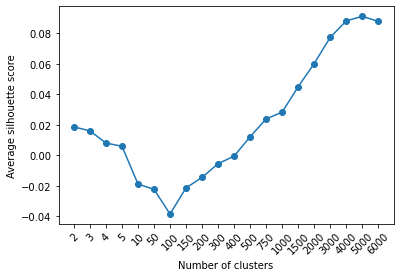

In [5]:
silhouette_scores = pred_cluster_labels["K-means clustering"]["metric_values"]
xs = range(len(ks))

plt.scatter(xs, silhouette_scores)
plt.xticks(xs, ks, rotation=45)
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.plot(xs, silhouette_scores)
plt.show()

In [6]:
# Compute cluster size ratios (maximum cluster size / minimum cluster size)
for labels in pred_cluster_labels["K-means clustering"]["labels"]:
    labels_unique, labels_counts = np.unique(labels, return_counts=True)
    num_clusters = len(labels_unique)
    max_cluster_size = max(labels_counts)
    min_cluster_size = min(labels_counts)
    cluster_size_ratio = max_cluster_size / min_cluster_size
    print(f"{num_clusters} clusters: max={max_cluster_size}, min={min_cluster_size}, ratio={cluster_size_ratio}")
    print("---")

2 clusters: max=5641, min=4359, ratio=1.2941041523285157
---
3 clusters: max=3624, min=2930, ratio=1.2368600682593858
---
4 clusters: max=3136, min=1378, ratio=2.2757619738751815
---
5 clusters: max=2656, min=1232, ratio=2.155844155844156
---
10 clusters: max=1797, min=410, ratio=4.382926829268293
---
50 clusters: max=714, min=11, ratio=64.9090909090909
---
100 clusters: max=346, min=5, ratio=69.2
---
150 clusters: max=337, min=3, ratio=112.33333333333333
---
200 clusters: max=280, min=1, ratio=280.0
---
300 clusters: max=188, min=1, ratio=188.0
---
400 clusters: max=163, min=1, ratio=163.0
---
500 clusters: max=163, min=1, ratio=163.0
---
750 clusters: max=186, min=1, ratio=186.0
---
1000 clusters: max=186, min=1, ratio=186.0
---
1500 clusters: max=181, min=1, ratio=181.0
---
2000 clusters: max=164, min=1, ratio=164.0
---
3000 clusters: max=138, min=1, ratio=138.0
---
4000 clusters: max=139, min=1, ratio=139.0
---
5000 clusters: max=61, min=1, ratio=61.0
---
6000 clusters: max=106, mi